**Подключение библиотек и скриптов**

In [81]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split, KFold, GridSearchCV

# 3. Модели
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

# 4. Метрики качества
from sklearn.metrics import mean_squared_error as mse, r2_score as r2

# 5. Для визуализации внешних картинок в ноутбуке
from IPython.display import Image

In [60]:
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

In [61]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [62]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        
    def fit(self, df):
        """Сохранение статистик"""
        self.medians = df[['LifeSquare', 'Healthcare_1']].median()
        
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        df[['LifeSquare', 'Healthcare_1']] = df[['LifeSquare', 'Healthcare_1']].fillna(self.medians)
        
        # 2. Выбросы (outliers)
        
        # 
        df.loc[(df['Square'] < 10), 'Square'] = df['Square'].median()
        
        # 
        df.loc[(df['LifeSquare'] < 10), 'LifeSquare'] = df['LifeSquare'].median()
        
        # 
        df.loc[(df['LifeSquare'] > df['Square']), 'LifeSquare'] = df['Square']
        
        # 
        df.loc[((df['KitchenSquare'] > df['LifeSquare']*0.3) | (df['KitchenSquare'] < 4)), 'KitchenSquare'] = df['KitchenSquare'].median()
        
        
        # 3. Новые фичи (features)
        
        # Доля спален в общем кол-ве комнат
        #df['bedroom_share'] = df['total_bedrooms'] / df['total_rooms'] * 100
        # Сколько человек в среднем живут в одной комнате
        #df['population_per_room'] = df['population'] / df['total_rooms']
        
        #df['HouseYear'] = df['HouseYear'] // 5 * 5

        #for feat in ['DistrictId', 'Rooms','Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear','Social_1','Social_2','Social_3','Healthcare_1', 'Helthcare_2', 'Shops_1']:
        #    df[feat] = (df[feat] - df[feat].min()) / (df[feat].max() - df[feat].min())
        
        #df['Price'] = df['Price'] // 5000 * 5000
        
        # 4. Обработка категорий
        df = pd.concat([df, pd.get_dummies(df['Ecology_2'], prefix='Ecology_2', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Ecology_3'], prefix='Ecology_3', dtype='int8')], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Shops_2'], prefix='Shops_2', dtype='int8')], axis=1)
        
        return df

In [63]:
DATASET_PATH_TRAIN = 'train.csv'
DATASET_PATH_TEST = 'test.csv'

In [64]:
df = pd.read_csv(DATASET_PATH_TRAIN)
df = reduce_mem_usage(df)

pipe = DataPipeline()
pipe.fit(df)
df = pipe.transform(df)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [65]:
df.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,B,184966.937500,0,1,0,1,0,1
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,1,16,B,300009.437500,0,1,0,1,0,1
2,4765,53,2.0,44.947952,29.197611,6.0,8,12.0,1968,0.049637,...,1,3,B,220925.906250,0,1,0,1,0,1
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,0,5,B,175616.234375,0,1,0,1,0,1
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,B,150226.531250,0,1,0,1,0,1


In [66]:
df.isnull().sum()

Id               0
DistrictId       0
Rooms            0
Square           0
LifeSquare       0
KitchenSquare    0
Floor            0
HouseFloor       0
HouseYear        0
Ecology_1        0
Ecology_2        0
Ecology_3        0
Social_1         0
Social_2         0
Social_3         0
Healthcare_1     0
Helthcare_2      0
Shops_1          0
Shops_2          0
Price            0
Ecology_2_A      0
Ecology_2_B      0
Ecology_3_A      0
Ecology_3_B      0
Shops_2_A        0
Shops_2_B        0
dtype: int64

In [67]:
df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Healthcare_1,Helthcare_2,Shops_1,Price,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,...,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.374352,35.959919,6.713600,8.526700,12.609400,3.990166e+03,0.118858,...,1026.358887,1.319500,4.231300,214138.859375,0.009700,0.990300,0.027500,0.972500,0.082500,0.917500
std,4859.01902,43.587592,0.839512,20.979980,16.629345,1.778789,5.241148,6.775974,2.005003e+05,0.119025,...,746.662842,1.493601,4.806341,92872.289062,0.098015,0.098015,0.163543,0.163543,0.275139,0.275139
min,0.00000,0.000000,0.000000,13.784864,10.523869,4.000000,1.000000,0.000000,1.910000e+03,0.000000,...,0.000000,0.000000,0.000000,59174.777344,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4169.50000,20.000000,1.000000,41.794393,27.619654,6.000000,4.000000,9.000000,1.974000e+03,0.017647,...,830.000000,0.000000,1.000000,153872.628906,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
50%,8394.50000,36.000000,2.000000,52.513580,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,...,900.000000,1.000000,3.000000,192269.648438,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
75%,12592.50000,75.000000,2.000000,65.900627,41.178370,7.000000,12.000000,17.000000,2.001000e+03,0.195781,...,990.000000,2.000000,6.000000,249135.460938,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
max,16798.00000,209.000000,19.000000,641.065186,638.163208,30.000000,42.000000,117.000000,2.005201e+07,0.521867,...,4849.000000,6.000000,23.000000,633233.437500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [68]:
df.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
Ecology_2_A          int8
Ecology_2_B          int8
Ecology_3_A          int8
Ecology_3_B          int8
Shops_2_A            int8
Shops_2_B            int8
dtype: object

In [69]:
df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [70]:
feature_names = ['DistrictId', 'Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Social_1', 'Social_2', 'Social_3', 'Healthcare_1', 'Helthcare_2', 'Shops_1', 
                 'Ecology_2_A', 'Ecology_2_B', 'Ecology_3_A', 'Ecology_3_B', 'Shops_2_A', 'Shops_2_B']

target_name = 'Price'

In [71]:
df = df[feature_names + [target_name]]
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Price
0,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,33,...,900.0,0,11,0,1,0,1,0,1,184966.937500
1,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,46,...,240.0,1,16,0,1,0,1,0,1,300009.437500
2,53,2.0,44.947952,29.197611,6.0,8,12.0,1968,0.049637,34,...,229.0,1,3,0,1,0,1,0,1,220925.906250
3,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,23,...,1084.0,0,5,0,1,0,1,0,1,175616.234375
4,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,35,...,2078.0,2,4,0,1,0,1,0,1,150226.531250


In [72]:
feature_names_for_stand = df[feature_names].select_dtypes(include=['float32', 'float16', 'int8', 'int16', 'int32']).columns.tolist()
feature_names_for_stand

['DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Ecology_2_A',
 'Ecology_2_B',
 'Ecology_3_A',
 'Ecology_3_B',
 'Shops_2_A',
 'Shops_2_B']

In [97]:
# MinMaxScaler() Для каждой фичи x делает: (x - min) / (max - min)
# StandardScaler() Для каждой фичи х делает: (x - mean) / std
# RobustScaler() Для каждой фичи х делает: (x - median) / (q75 - q25)

scaler = StandardScaler()
stand_features = scaler.fit_transform(df[feature_names_for_stand])

In [98]:
df[feature_names_for_stand] = pd.DataFrame(stand_features, columns=feature_names_for_stand)
df.head()

,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,...,Healthcare_1,Helthcare_2,Shops_1,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B,Price
0,-0.353348,0.130439,-0.400058,-0.391927,-0.401192,-0.291306,-0.532703,-0.010081,-0.250529,0.474169,...,-0.169240,-0.883480,1.408356,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864,184966.937500
1,-0.215687,1.321667,0.443745,0.245940,0.723225,-0.291306,-0.532703,-0.010036,-0.998053,1.215681,...,-1.053217,-0.213923,2.448700,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864,300009.437500
2,0.059635,0.130439,-0.544661,-0.406670,-0.401192,-0.100498,-0.089940,-0.010086,-0.581588,0.531208,...,-1.067950,-0.213923,-0.256195,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864,220925.906250
3,0.174352,0.130439,-0.144019,1.008604,1.285433,-0.100498,0.647998,-0.010041,2.680470,-0.096225,...,0.077202,-0.883480,0.159943,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864,175616.234375
4,1.115034,-1.060788,-0.797236,-0.732702,0.161016,0.471924,-0.089940,-0.010046,-0.894969,0.588247,...,1.408526,0.455633,-0.048126,-0.09897,0.09897,-0.16816,0.16816,-0.299864,0.299864,150226.531250


In [108]:
X = df[feature_names]
y = df[target_name]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=42)

In [76]:
def evaluate_preds(true_values, pred_values, save=False):
    """Оценка качества модели и график preds vs true"""
    
    print("R2:\t" + str(round(r2(true_values, pred_values), 3)) + "\n" +
          "RMSE:\t" + str(round(np.sqrt(mse(true_values, pred_values)), 3)) + "\n" +
          "MSE:\t" + str(round(mse(true_values, pred_values), 3))
         )
    
    plt.figure(figsize=(8,8))
    
    sns.scatterplot(x=pred_values, y=true_values)
    plt.plot([0, 650000], [0, 650000], linestyle='--', color='black')  # диагональ, где true_values = pred_values
    
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('True vs Predicted values')
    
    if save == True:
        plt.savefig(REPORTS_FILE_PATH + 'report.png')
    plt.show()

R2:	0.527
RMSE:	63880.244
MSE:	4080685585.175


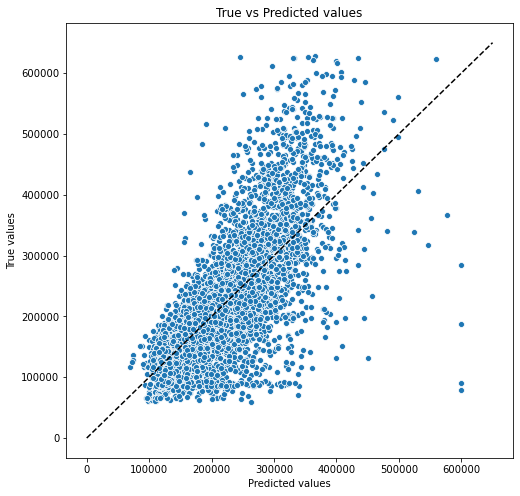

In [109]:
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

y_train_preds = lr_model.predict(X_train)
# Постпроцессинг
y_train_preds = np.clip(y_train_preds, a_min=50000, a_max=600000)

evaluate_preds(y_train, y_train_preds)

R2:	0.517
RMSE:	64476.367
MSE:	4157201852.158


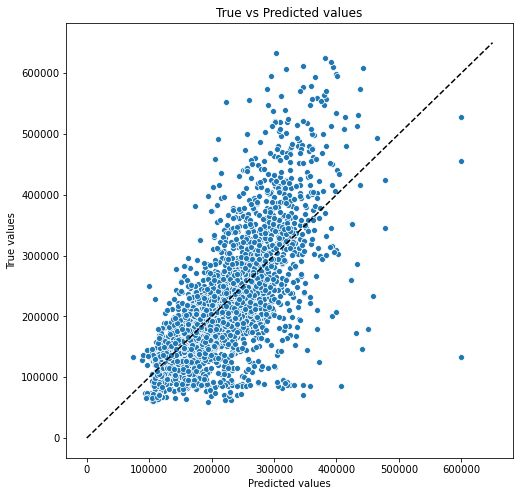

In [113]:
y_test_preds = lr_model.predict(X_test)

# Постпроцессинг
y_test_preds = np.clip(y_test_preds, a_min=50000, a_max=600000)

evaluate_preds(y_test, y_test_preds)

R2:	0.715
RMSE:	49609.978
MSE:	2461149922.454


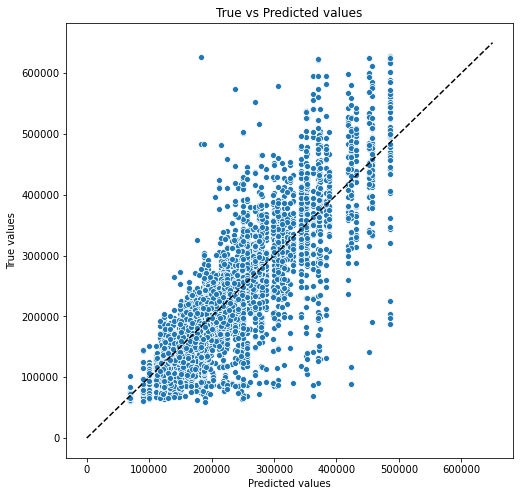

In [114]:
dt_model = DecisionTreeRegressor(criterion='mse', 
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42)
dt_model.fit(X_train, y_train)

y_train_preds = dt_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.636
RMSE:	55982.718
MSE:	3134064738.078


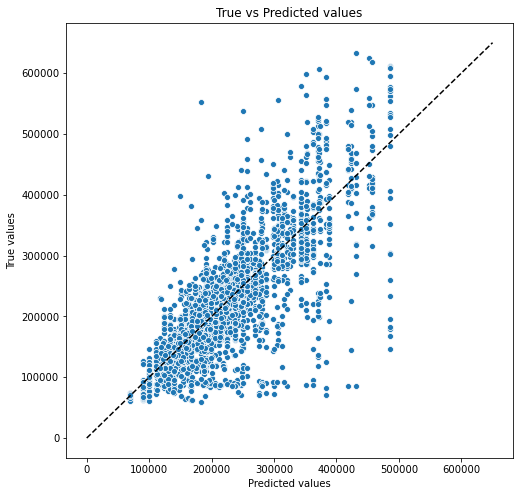

In [115]:
y_test_preds = dt_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

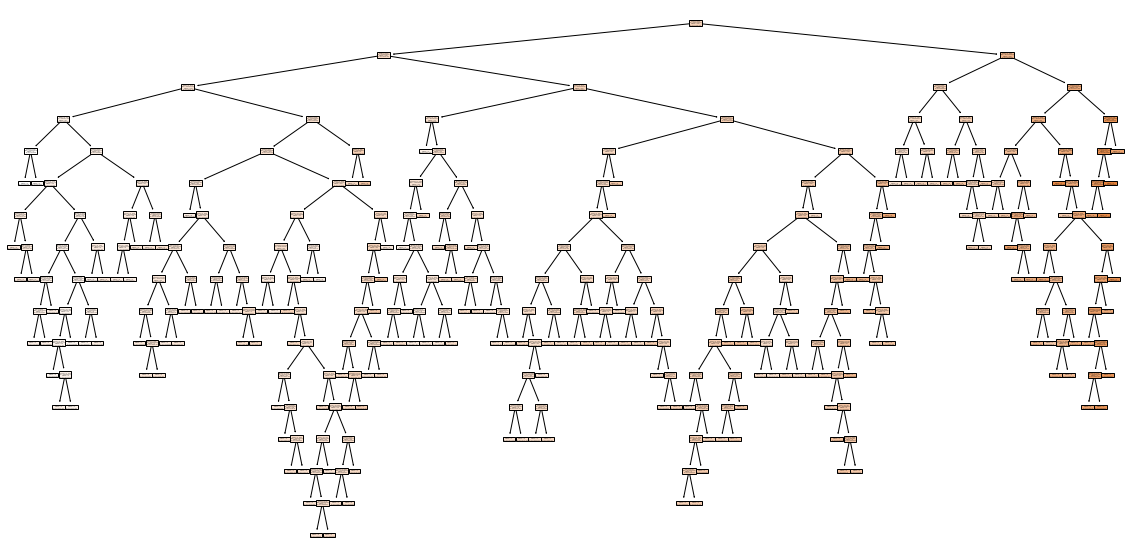

In [116]:
plt.figure(figsize=(20, 10))
plot_tree(dt_model, feature_names=X_train.columns, filled = True);

R2:	0.733
RMSE:	48020.773
MSE:	2305994639.711


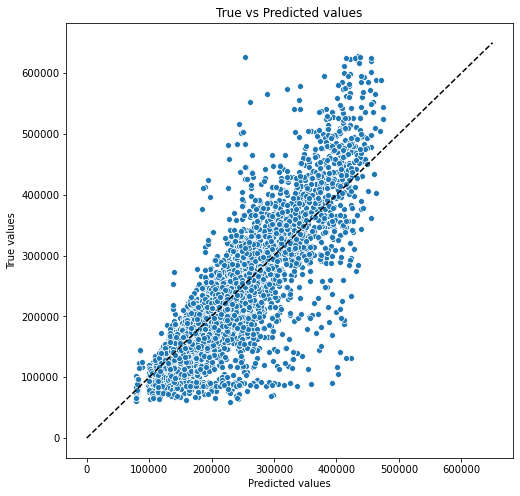

In [117]:
rf_model = RandomForestRegressor(criterion='mse',
                                 max_depth=20, # глубина дерева  
                                 min_samples_leaf=30, # минимальное кол-во наблюдений в листе дерева
                                 random_state=42,
                                 n_estimators=100  # кол-во деревьев
                                 )

rf_model.fit(X_train, y_train)
y_train_preds = rf_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.667
RMSE:	53525.92
MSE:	2865024064.534


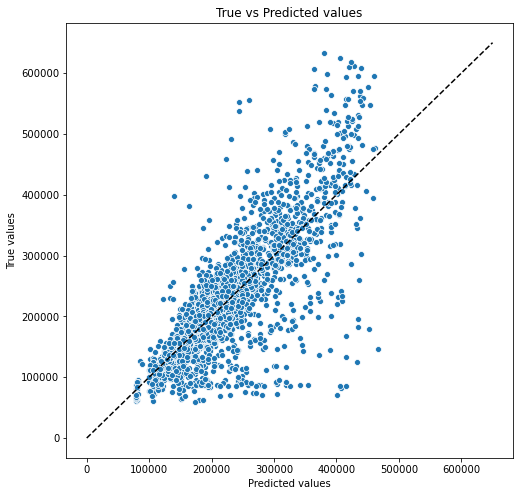

In [118]:
y_test_preds = rf_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

R2:	0.9
RMSE:	29404.915
MSE:	864649041.234


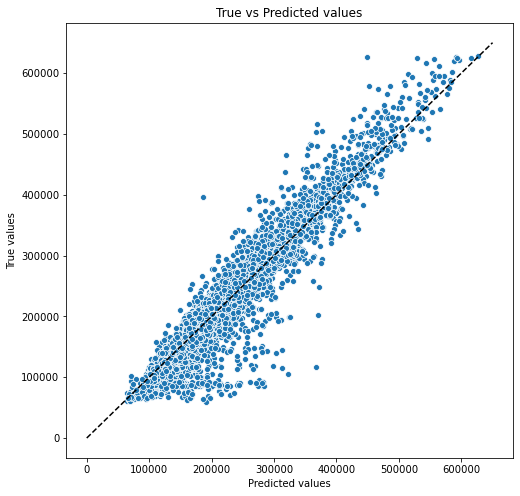

In [123]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=7,
                                     min_samples_leaf=10,
                                     random_state=42,  
                                     n_estimators=100)
gb_model.fit(X_train, y_train)

y_train_preds = gb_model.predict(X_train)
evaluate_preds(y_train, y_train_preds)

R2:	0.731
RMSE:	48156.059
MSE:	2319006021.0


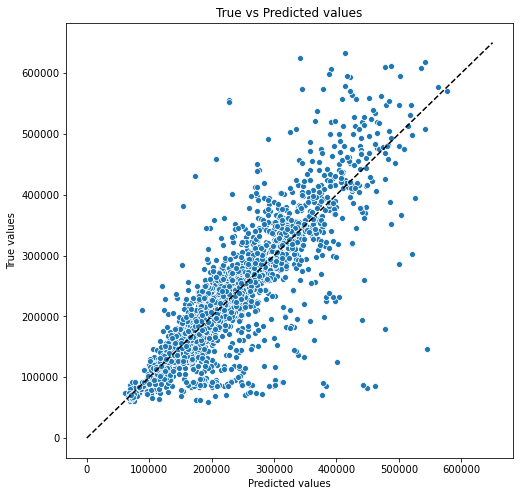

In [120]:
y_test_preds = gb_model.predict(X_test)
evaluate_preds(y_test, y_test_preds)

In [121]:
X_train.shape[0] // 5

1340